In [1]:
import os
import numpy as np
import imageio

In [2]:
raw_path = '../md17'

In [4]:
molecule_files = {1:'H', 6: 'C', 8:'O', 7:'N'}
def read_mol(mol_name):
    npz_file = np.load(os.path.join(raw_path, molecule_files[mol_name]))
    z = npz_file['z']
    x_all = npz_file['R']
    x = x_all[:, z > 1]
    return z, x_all, x

In [5]:
from xyz2mol import *
def get_mol(z, x):
    mols = xyz2mol(z.tolist(), x.tolist(),
                charge=0,
                use_graph=True,
                allow_charged_fragments=True,
                embed_chiral=True,
                use_huckel=False)
    return mols[0]

In [15]:
import matplotlib.pyplot as plt
def plot(x_gt, x_pred, path):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    lw = 1.2

    for p1, p2 in x_gt:
        pos_gt = list(zip(p1, p2))
        ax.plot(pos_gt[0], pos_gt[1], pos_gt[2], color='r', ls='-', linewidth=lw)
    
    for p1, p2 in x_pred:
        pos_pred = list(zip(p1, p2))
        ax.plot(pos_pred[0], pos_pred[1], pos_pred[2], color='b', ls='-', linewidth=lw)
    
    plt.savefig(path)

In [28]:
def get_bonds(mol):
    pos_pair = []
    for bond in mol.GetBonds():
        atom1_idx = bond.GetBeginAtomIdx()
        atom2_idx = bond.GetEndAtomIdx()
        atom1_symbol = mol.GetAtomWithIdx(atom1_idx).GetSymbol()
        atom2_symbol = mol.GetAtomWithIdx(atom2_idx).GetSymbol()
        # if atom1_symbol == 'H' or atom2_symbol == 'H':
        #     continue
        atom1_pos = list(mol.GetConformer().GetAtomPosition(atom1_idx))
        atom2_pos = list(mol.GetConformer().GetAtomPosition(atom2_idx))
        pos_pair.append((atom1_pos, atom2_pos))
    return pos_pair

In [8]:
molecule_files = dict(
    Aspirin="aspirin_dft.npz",
    Benzene="benzene_dft.npz",
    Ethanol="ethanol_dft.npz",
    Malonaldehyde="malonaldehyde_dft.npz",
    Naphthalene="naphthalene_dft.npz",
    Salicylic="salicylic_dft.npz",
    Toluene="toluene_dft.npz",
    Uracil="uracil_dft.npz",
)

In [58]:
tar_mol = 'Uracil'
z, x_all, x = read_mol(tar_mol)
print(z)

[6 6 7 6 7 6 8 8 1 1 1 1]


In [59]:
now_index = 128047
past_index = [now_index - i*10  for i in range(10, 0, -1)]
print(past_index)
x_now = x_all[now_index]
mol_gt = get_mol(z, x_now)
pair_gt = get_bonds(mol_gt)

[127947, 127957, 127967, 127977, 127987, 127997, 128007, 128017, 128027, 128037]


(8, 3)


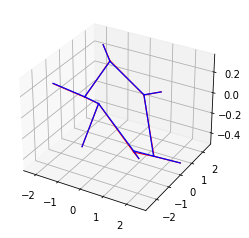

In [60]:
estag_pred = np.array([[ 1.5626e+00,  1.3470e-01, -4.2686e-01],
        [ 1.3546e+00, -1.1379e+00, -2.4442e-01],
        [ 8.7156e-02, -1.5669e+00,  1.6798e-01],
        [-1.0801e+00, -6.2163e-01,  6.3953e-02],
        [-6.6833e-01,  6.4951e-01,  3.0130e-01],
        [ 5.6741e-01,  1.1699e+00,  2.1489e-03],
        [-2.2218e+00, -1.0695e+00,  1.6782e-01],
        [ 7.1248e-01,  2.3828e+00, -8.3180e-02]])
print(estag_pred.shape)
x_now[z>1] = estag_pred
mol_estag = get_mol(z, x_now)
pair_estag = get_bonds(mol_estag)
plot(pair_gt, pair_estag, f'../hh/3d_{tar_mol}_estag.svg')

(8, 3)


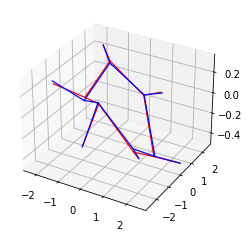

In [61]:
egnn_pred = np.array([[ 1.6001,  0.1901, -0.4319],
        [ 1.3362, -1.1318, -0.2270],
        [ 0.0701, -1.5887,  0.1785],
        [-1.0937, -0.6551,  0.0325],
        [-0.6718,  0.6429,  0.2888],
        [ 0.5767,  1.1703,  0.0048],
        [-2.2425, -1.1062,  0.1948],
        [ 0.7488,  2.4150, -0.0914]])
print(egnn_pred.shape)
x_now[z>1] = egnn_pred
mol_egnn = get_mol(z, x_now)
pair_egnn = get_bonds(mol_egnn)
plot(pair_gt, pair_egnn, f'../hh/3d_{tar_mol}_egnn.svg')